# Imports and Definitions

In [104]:
!pip install xgboost --quiet
!pip install holidays --quiet

In [105]:
%run generic_common_library.py

<Figure size 640x480 with 0 Axes>

# Bring in Data (TSF)

In [106]:
def load_tsf_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Parse metadata
    column_names = []
    data_started = False
    data = []

    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith("@attribute"):
            parts = line.split()
            column_names.append(parts[1])
        elif line.startswith("@data"):
            data_started = True
            continue
        elif data_started:
            # Split into metadata and series
            meta_parts = line.split(":")
            meta_data = meta_parts[:-1]
            series = meta_parts[-1]
            series_data = series.strip().split(",")
            series_data = [float(x) if x != "?" else np.nan for x in series_data]
            data.append(meta_data + [series_data])

    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names + ["series_values"])
    return df

In [107]:
file_path = "us_births_dataset.tsf"  # replace with your actual path
tsf_df = load_tsf_file(file_path)

# Show the result
tsf_df

,series_name,start_timestamp,series_values
0,T1,1969-01-01 00-00-00,"[8486.0, 9002.0, 9542.0, 8960.0, 8390.0, 9560...."


In [108]:
def expand_daily_series(df, time_column='start_timestamp', series_column='series_values'):
    # Step 1: Repeat metadata for each value in series_values
    df_expanded = df.explode(series_column).reset_index(drop=True)

    # Step 2: Convert values to float (if not already)
    df_expanded[series_column] = df_expanded[series_column].astype(float)
    df_expanded = df_expanded.rename(columns={series_column:'METRIC'})

    # Step 3: If there's a start date, build daily timestamps
    if time_column in df.columns:
        # Repeat start_timestamp for each exploded row
        df_expanded['time_index'] = pd.to_datetime(df_expanded[time_column])
        df_expanded['day_offset'] = df_expanded.index
        df_expanded['DATETIME'] = df_expanded['time_index'] + pd.to_timedelta(df_expanded['day_offset'], unit='D')
        df_expanded['DATETIME'] = df_expanded['DATETIME'].apply(lambda x: x.replace(tzinfo=None))
        df_expanded.drop(columns=['start_timestamp', 'series_name', 'time_index', 'day_offset'], inplace=True)
    else:
        # If no start_timestamp, just create an integer time index
        df_expanded['day'] = df.groupby(df.index).cumcount()

    return df_expanded


In [ ]:
input_df = expand_daily_series(tsf_df)
input_df.head()

# Plot Data

<Axes: xlabel='DATETIME'>

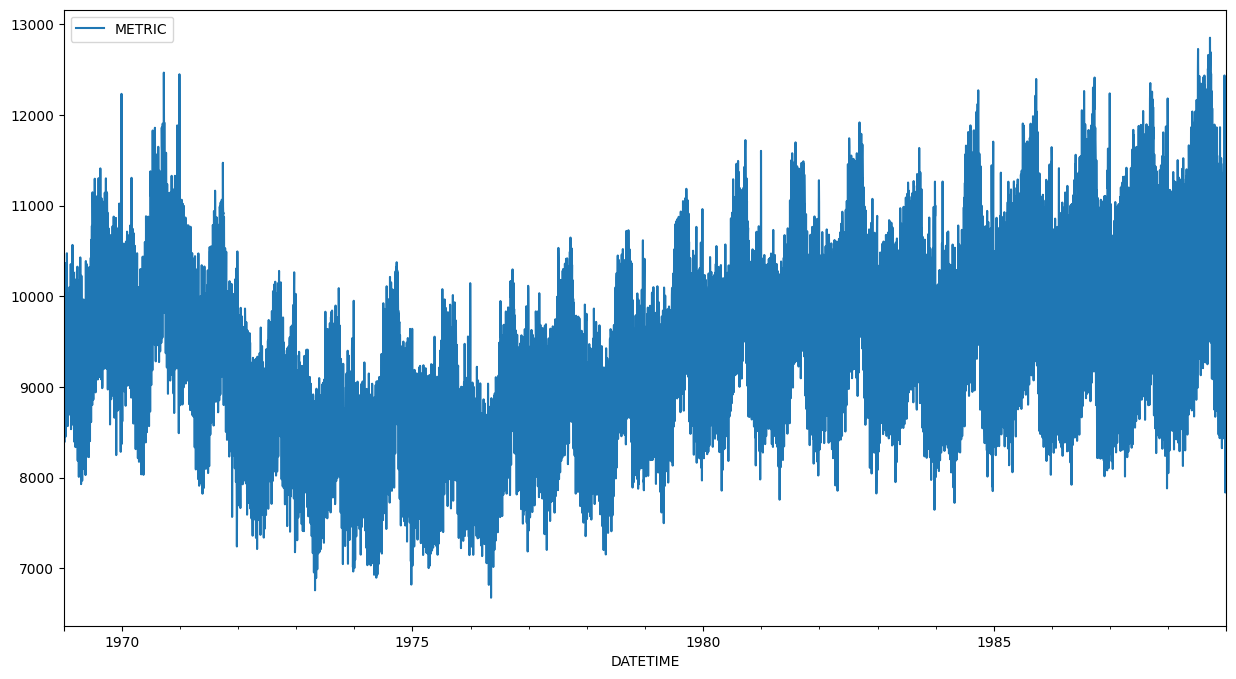

In [110]:
fig, ax = plt.subplots(figsize=(15,8))
input_df.plot(x = 'DATETIME', y = 'METRIC',ax = ax)

# Generate Features

In [111]:
%run forecasting_generate_features.py

<Figure size 640x480 with 0 Axes>

In [112]:
features_df, feature_list = add_features(
    input_df = input_df,
    metric = 'METRIC',
    date_field = 'DATETIME'
)

/opt/conda/lib/python3.10/site-packages/holidays/countries/india.py:180: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)


# Identify best params for model fit

In [113]:
%run forecasting_generate_best_parameters.py

In [ ]:
# Generate the best hyperparameters for the current channel's dataset
best_params = generate_best_parameters(
    input_df = features_df,
    metric = 'METRIC',
    feature_list = feature_list,
    scoring_method = 'neg_root_mean_squared_error'
)

Optimizing for: neg_root_mean_squared_error
Param Grid contains 11664 combinations of parameters

Step 1: Fill up a reduced param Grid using Randomized Search


# Fit Model

In [ ]:
def fit_xgboost(input_df, metric, feature_list, objective, best_params, min_cv_split_size):
    # Initialize an XGBoost regressor with the best parameters found during hyperparameter tuning
    xgboost_reg = xgb.XGBRegressor(
        colsample_bytree = best_params['colsample_bytree'],
        gamma = best_params['gamma'],
        learning_rate = best_params['learning_rate'],
        max_depth = best_params['max_depth'],
        min_child_weight = best_params['min_child_weight'],
        n_estimators = best_params['n_estimators'],
        subsample = best_params['subsample'],
        objective = objective  # e.g., 'reg:squarederror'
    )

    # Select input features (X) and target variable (y)
    X = input_df[feature_list]
    y = input_df[metric]  # Assumes 'metric' is a global variable defined elsewhere

    # Create custom cross-validation splits with minimum training size enforced
    cv_splits = list(min_train_size_forward_split(X, n_splits=5, min_train_size=min_cv_split_size))

    # Evaluate model using cross-validation with RMSE (root mean squared error)
    rms_errors = cross_val_score(
        xgboost_reg, X, y,
        scoring='neg_root_mean_squared_error',
        cv=cv_splits
    )

    # Evaluate model using cross-validation with MAPE (mean absolute percentage error)
    map_errors = cross_val_score(
        xgboost_reg, X, y,
        scoring='neg_mean_absolute_percentage_error',
        cv=cv_splits
    )

    # Train the XGBoost model on the full dataset
    xgboost_reg.fit(X, y)

    # Output evaluation metrics from cross-validation
    print("Root Mean Squared Errors for each split:", rms_errors)
    print("AVG RMSE: %f" % ((rms_errors * -1).mean()))  # Convert negative scores to positive
    print("MAPE for each split:", map_errors)
    print("AVG MAPE: %f" % ((map_errors * -1).mean()))  # Convert negative scores to positive

    # Return the trained XGBoost model
    return xgboost_reg

In [ ]:
# Fit an XGBoost model using the best parameters and training data
fitted_model = fit_xgboost(
    input_df = features_df,
    metric = 'METRIC',
    feature_list = feature_list,
    objective = "reg:squarederror",
    best_params = best_params,
    min_cv_split_size = 365  # Minimum training data size per fold
)

## Feature Importances

In [ ]:
feature_importance = pd.DataFrame({'label': fitted_model.feature_names_in_, 'importance': fitted_model.feature_importances_}, columns=['label', 'importance'])

feature_importance.sort_values(by='importance', ascending=False).head(n=20)

# Generate Predictions

In [ ]:
metric = 'METRIC'
date_field = 'DATETIME'

# Initialize an empty DataFrame to store all predictions
all_predictions_df = pd.DataFrame()

# Extract real data (actual values) from the DataFrame for the current channel
real_data = features_df.copy()[[date_field, metric]]
real_data.loc[:, 'isFuture'] = False  # Mark these rows as real data (not future)

# Create a DataFrame for future dates to make predictions on
future = pd.date_range(start=(real_data[date_field].max() + timedelta(1)), periods=364, freq='1d')  # 364 days ahead
future_df = pd.DataFrame(future, columns=[date_field])  # Create DataFrame for future dates
future_df[date_field] = pd.to_datetime(future_df[date_field])  # Ensure proper datetime format
future_df.loc[:, 'isFuture'] = True  # Mark these rows as future data (predictions)

# Combine real and future data into a single DataFrame
real_and_future = pd.concat([real_data, future_df])

# Add necessary features to both real and future data (using the 'add_features' function)
real_and_future, feature_list = add_features(
    input_df = real_and_future,
    metric = metric,
    date_field = date_field
)

# Make predictions using the loaded model
real_and_future['predictions'] = fitted_model.predict(real_and_future[feature_list])

# Vizualize Predictions

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
real_and_future[real_and_future.DATETIME >= datetime(1986,1,1)].plot(x = 'DATETIME', y = 'METRIC',ax = ax)
real_and_future[real_and_future.isFuture == True].plot(x = 'DATETIME', y = 'predictions',ax = ax)